## Imports

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## PreProcessing and Cleaning

In [2]:
#PreProcessing and Cleaning
import re # regular expression model for getting rid of patterns
from sklearn.preprocessing import LabelEncoder # for label encoding

#Import data
data = pd.read_csv("reply_classification_dataset.csv")
print(f"data original size: {data.shape}")

#Get rid of NULL values

df = data.dropna()
print(f"data size after dropping null values: {data.shape}")

#Cleaning the texts
def clean_text(text):

    #Safe handling
    if not isinstance(text, str):
        return None

    def remove_non_ascii(text):
        return text.encode("ascii", "ignore").decode()

    text = remove_non_ascii(text)
    text = re.sub(r"\s+", " ", text)  # collapse multiple spaces
    text = text.strip() #removes unnecessary early and after spaces
    return text.lower()

for col in df.columns:
    df[col] = df[col].apply(clean_text)

df = df.drop_duplicates(subset=["reply", "label"], keep="last")
print(f"data size after dropping duplicate values: {df.shape}")

#Encoding the differnt labels
LE = LabelEncoder()
df["encoded"] = LE.fit_transform(df["label"]) #values are assigned alphabetically, so neg->0, neutral->1, pos->2

data original size: (2129, 2)
data size after dropping null values: (2129, 2)
data size after dropping duplicate values: (321, 2)


### Too many duplicates

In [3]:
df.head()

,reply,label,encoded
0,can we discuss pricing??,neutral,1
1,"im excited to explore this further, plz send c...",positive,2
2,we not looking for new solutions.,negative,0
3,could u clarify features included?,neutral,1
4,"lets,, schedule a meeting to dive deeper",positive,2


# EDA

encoded
1    121
2    114
0     86
Name: count, dtype: int64


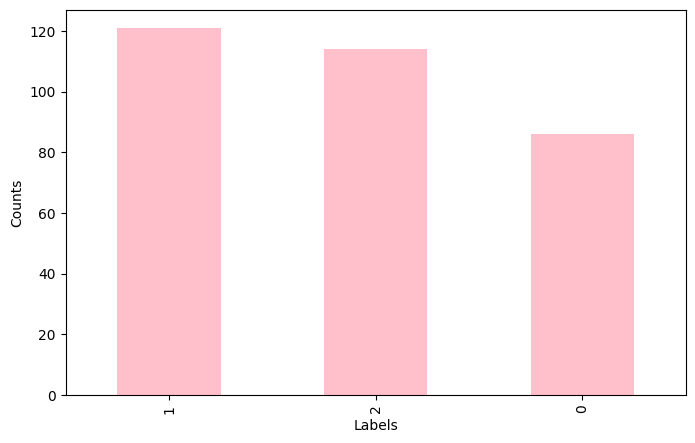

In [4]:
plt.figure(figsize=(8,5))  
ax = df['encoded'].value_counts().plot(kind='bar', color='pink')
ax.set_xlabel("Labels")
ax.set_ylabel("Counts")
print(df['encoded'].value_counts())
plt.show()

### There is Class Imbalance here (will use stratified split for traing and testing, and class weights so that i penalize model harder for wrong clasification of a class whose frequency is lesss)

## Train-Test-Split + Embeddings

In [5]:
test_size = 0.2

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["reply"], df["encoded"], test_size=test_size, random_state=42, stratify=df["encoded"])

In [7]:
X_train.head()

1368       this could streamline, connect!
1799                   not good fit for us
1813            send pricing structure plz
2120            not interested, thank you.
3       could u clarify features included?
Name: reply, dtype: object

In [8]:
#Encoding the vectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

scaler = StandardScaler(with_mean=False)  # TF-IDF is sparse
X_train_vec = scaler.fit_transform(X_train_vec)
X_test_vec = scaler.transform(X_test_vec)

#### Note, here spliting before Vectorizing is important or else this will lead to train-test-leakage

## Training a ML Model (Log Reg)

In [9]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=500, class_weight="balanced")
lr_model.fit(X_train_vec, y_train)


LogisticRegression(class_weight='balanced', max_iter=500)

In [10]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = lr_model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))


Accuracy: 0.9846153846153847
F1 Score: 0.9846220648652259


In [11]:
sample_text = ["I am good boy", "i am not feeling well", " im looking forward to presentation!", "plz send feature roadmap", "we not looking for new solutions."]
sample_tfidf = vectorizer.transform(sample_text)

preds = lr_model.predict(sample_tfidf)
print(preds)

[1 0 2 1 0]


#### due to tf-idf having many features, and the data being very small we are getting a f1 score of 1. (PERFECT SCORE) usally it is not possible, that is if i put in an actual negative senetence that is entirely different from these reviews dataset we will get a incorrect prediciton

## Training a ML Model (Light Gradient Boosting Machine)

In [12]:
!C:\Users\cw\AppData\Local\Programs\Python\Python312\python.exe -m pip install lightgbm
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    num_leaves=31,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    verbose=-1,
    class_weight="balanced"
)
lgb_model.fit(X_train_vec, y_train)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\cw\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


LGBMClassifier(class_weight='balanced', max_depth=6, verbose=-1)

In [13]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_pred = lgb_model.predict(X_test_vec)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")  # weighted → handles class imbalance
print("Accuracy:", acc)
print("Weighted F1:", f1)

Accuracy: 0.8153846153846154
Weighted F1: 0.8175609324545495


## Function with params as -> tf-idf feature, learning rate, number_of_iters, L1_lambda1, L2_lambda2

In [14]:


def train_and_test_simple_ml_model(tfidf_params, lr, n_iters, model_name, lambda_l1 = 0.1, lambda_l2=0.1):
    c = 1/lr

    vectorizer = TfidfVectorizer(max_features=tfidf_params)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    scaler = StandardScaler(with_mean=False)  # TF-IDF is sparse
    X_train_vec = scaler.fit_transform(X_train_vec)
    X_test_vec = scaler.transform(X_test_vec)

    
    if model_name == 'lgb':
        model = lgb.LGBMClassifier(
            num_leaves=31,
            max_depth=6,
            learning_rate=lr,
            n_estimators=100,
            lambda_l1= lambda_l1,  
            lambda_l2= lambda_l2,  
            verbose=-1
        )
        model.fit(X_train_vec, y_train)

    if model_name == 'logreg':
        model = LogisticRegression(max_iter=n_iters, C=c, solver='saga')
        model.fit(X_train_vec, y_train)

    predsi = model.predict(X_test_vec)
    train_predsi = model.predict(X_train_vec)

    train_acc = accuracy_score(y_train, train_predsi)
    train_f1 = f1_score(y_train, train_predsi, average="weighted")
    
    acc = accuracy_score(y_test, predsi)
    f1 = f1_score(y_test, predsi, average="weighted")  # weighted → handles class imbalance
    


    print(f"{model_name:<8} | {n_iters:<7} | {lr:<5} | {tfidf_params:<15} | "
      f"Test Acc: {acc:.4f} | Test F1: {f1:.4f} | "
      f"Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")

    return acc, f1, model, vectorizer, scaler



## Manual Grid Search CV

In [15]:
import warnings
warnings.filterwarnings("ignore")

tfidf_options = [10, 20, 50, 75, 100, 500, 1000]
lr_options = [0.01, 0.05, 0.1, 0.3, 0.9, 0.001]
n_iters_options = [10, 25, 50, 100]

print(f"{'Model':<8} | {'n_iters':<7} | {'lr':<6} | {'TF-IDF':<20} | {'Test Acc':<10} | {'Test F1':<10} | {'Train Acc':<10} | {'Train F1':<10}")
print("-" * 110)

max_f1 = 0;
tfidfs = 0
rate = 0 
iters = 0
model_name= None

for tfidf_param in tfidf_options:
    for lr in lr_options:
        for n_iter in n_iters_options:
            acc1, f11, m1, v1, s1 = train_and_test_simple_ml_model(tfidf_param, lr, n_iter, "lgb")
            acc2, f12, m2, v2, s2 = train_and_test_simple_ml_model(tfidf_param, lr, n_iter, "logreg")
            if(f11 > max_f1):
                max_f1 = f11;
                tfidfs = tfidf_param
                rate = lr 
                iters = n_iter
                model_name="lgb"
            if(f12 > max_f1):
                max_f1 = f12;
                tfidfs = tfidf_param
                rate = lr 
                iters = n_iter
                model_name="logreg"

Model    | n_iters | lr     | TF-IDF               | Test Acc   | Test F1    | Train Acc  | Train F1  
--------------------------------------------------------------------------------------------------------------
lgb      | 10      | 0.01  | 10              | Test Acc: 0.9077 | Test F1: 0.9081 | Train Acc: 0.9141 | Train F1: 0.9131
logreg   | 10      | 0.01  | 10              | Test Acc: 0.8615 | Test F1: 0.8623 | Train Acc: 0.9297 | Train F1: 0.9299
lgb      | 25      | 0.01  | 10              | Test Acc: 0.9077 | Test F1: 0.9081 | Train Acc: 0.9141 | Train F1: 0.9131
logreg   | 25      | 0.01  | 10              | Test Acc: 0.8615 | Test F1: 0.8623 | Train Acc: 0.9297 | Train F1: 0.9299
lgb      | 50      | 0.01  | 10              | Test Acc: 0.9077 | Test F1: 0.9081 | Train Acc: 0.9141 | Train F1: 0.9131
logreg   | 50      | 0.01  | 10              | Test Acc: 0.8615 | Test F1: 0.8623 | Train Acc: 0.9297 | Train F1: 0.9299
lgb      | 100     | 0.01  | 10              | Test Acc: 0.9

In [16]:
#Best Model -> 
acc, f1, m, v, s = train_and_test_simple_ml_model(tfidfs, rate, iters, model_name)

logreg   | 10      | 0.1   | 500             | Test Acc: 1.0000 | Test F1: 1.0000 | Train Acc: 1.0000 | Train F1: 1.0000


## I have decided to use logistic regression. Now i will export this using joblib, import the same in .py file and convert to API

In [17]:
import joblib

# After training inside your function:
joblib.dump(m, "model.pkl")
joblib.dump(v, "tfidf_vectorizer.pkl")
joblib.dump(s, "scaler.pkl")

print("Exported")

Exported


## Fine-Tune Transformer Based Model

In [18]:
!C:\Users\cw\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade torch datasets "transformers[torch]"


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\cw\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [19]:
from datasets import Dataset

train_ds = Dataset.from_dict({"text": X_train, "label": y_train})
val_ds = Dataset.from_dict({"text": X_test, "label": y_test})

In [20]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])


Map: 100%|████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 8029.86 examples/s]


In [21]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=3
)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",   
    logging_strategy="epoch" 
)

# Metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,  
    eval_dataset=val_ds,   
    compute_metrics=compute_metrics
)

# Training
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.026900,0.854997,0.707692,0.624129
2,0.667600,0.475436,0.923077,0.922752
3,0.352500,0.310623,0.923077,0.922752
4,0.205900,0.254464,0.923077,0.922752
5,0.160200,0.242973,0.938462,0.937821


TrainOutput(global_step=80, training_loss=0.482620844244957, metrics={'train_runtime': 52.9088, 'train_samples_per_second': 24.193, 'train_steps_per_second': 1.512, 'total_flos': 4636441635840.0, 'train_loss': 0.482620844244957, 'epoch': 5.0})

In [22]:
import torch
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

texts = [
    "I am very happy with this product!",
    "This is terrible, I hate it.",
    "It's okay, nothing special."
]

inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

model.eval() 
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = logits.argmax(dim=-1)

label_map = {0: "negative", 1: "neutral", 2: "positive"}
pred_labels = [label_map[p.item()] for p in predictions]

# Show results
for text, pred in zip(texts, pred_labels):
    print(f"Text: {text}\nPrediction: {pred}\n")


Text: I am very happy with this product!
Prediction: positive

Text: This is terrible, I hate it.
Prediction: positive

Text: It's okay, nothing special.
Prediction: negative



## Why Did I Select Logistic Regression over Transformer model & LGBM?.

#### First of all we have very less data, that is just ~2000 examples + too many duplicates. at the end we have ~330 examples
#### Transformers are Data Hungry models, so to fine tune them we wld need a lot of energy + for such small datasets there is no need of High computational transformer model.
#### Talking about LGBM, LGBM is boosting method and yes they perfom very good, but on such small datasets + sparse matrix [ tf-idf will create a matrix in which as it considers vocabualry of all documents, it will be 0 most of the time, hence here LGBM cant generalize easily
#### Logistic Regression, Simple model and for small datasets Log Regression is ok and due to its linear nature(which acts as a regularizer) we can generalise bettter compared to other 2 in this case, and the metrics talk the same

##### Metrics of my best ML model:->

##### logreg   | 10      | 0.01  | 500             | Test Acc: 0.9846 | Test F1: 0.9846 | Train Acc: 1.0000 | Train F1: 1.0000

##### Metrics of my transformer model ->

##### Epoch  5	 Training Loss: 0.137200	   ValidationLoss:  0.202737	    Accuracy: 0.938462	   F1:0.937821	    

### Comprasion between LGBM & LogReg was done in Grid-SearchCV, For Transformer and LogReg , apart from my reasoning, Seeing the metrics it is clear that Log Reg is performing better
